In [ ]:
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pathlib import Path
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
from datetime import datetime, timedelta
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, TextClassificationPipeline
from datasets import Dataset
import plotly.graph_objects as go
import plotly.express as gx

In [ ]:
# Setting up the subfolder to store sentiment data

project_root = Path.cwd().parent
sentiment_data_path = project_root / "data" / "sentiment-data"
sentiment_data_path.mkdir(exist_ok=True)

In [ ]:


df_targeted = pd.read_csv(sentiment_data_path / 'targetted_combined_headlines.csv')



In [ ]:
stop_words = set(ENGLISH_STOP_WORDS)


def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df_targeted['Processed_Headlines'] = df_targeted['Headlines'].astype(str).apply(preprocess_text)

df_targeted['Date'] = pd.to_datetime(df_targeted['Date'], utc=True).dt.date

print(df_targeted[['Date', 'Processed_Headlines']].head())

         Date                                Processed_Headlines
0  2009-08-07  dave sawyer microsoft bob nolan raxco software...
1  2009-08-07  study enterprises slash percent application pr...
2  2009-08-07  paragonreportcom complimentary market update a...
3  2009-08-10  thefortunefinancialcom free market research fw...
4  2009-08-10  new transformertm ipodiphone transformer setm ...


In [ ]:
df_targeted.to_csv(sentiment_data_path / 'processed_targetted_combined_headlines.csv',index=False)
df_targeted[['Headlines', 'Processed_Headlines']].head()

,Headlines,Processed_Headlines
0,dave sawyer from microsoft and bob nolan from ...,dave sawyer microsoft bob nolan raxco software...
1,study: enterprises can slash 88 percent off ap...,study enterprises slash percent application pr...
2,paragonreport.com complimentary market update ...,paragonreportcom complimentary market update a...
3,thefortunefinancial.com free market research o...,thefortunefinancialcom free market research fw...
4,"new ""transformer(tm)"" for ipod/iphone and ""tra...",new transformertm ipodiphone transformer setm ...


In [ ]:
os.environ['TOKENIZERS_PARALLELISM'] = "False"

In [ ]:
MODEL_NAME = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model =  BertForSequenceClassification.from_pretrained(MODEL_NAME)
# sentiment_pipeline = pipeline("text-classifiction", model=model, tokenizer=tokenizer)
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def get_sentiment_score(label):
    return{"POSITIVE": 1, "NEUTRAL": 0, "NEGATIVE": -1}.get(label.upper(), 0)

In [ ]:
import time
from tqdm import tqdm

def process_sentiment():
    # Load and prepare data
    df = pd.read_csv('/content/processed_targetted_combined_headlines.csv')
    df.dropna(subset=["Processed_Headlines"], inplace=True)
    dataset = Dataset.from_pandas(df[["Date", "Stock", "Headlines", "Processed_Headlines"]])

    # Manual batching
    batch_size = 32
    labels, scores = [], []

    start_time = time.time()
    total_batches = len(dataset) // batch_size + 1

    with tqdm(total=total_batches, desc="Processing Sentiment", unit="batch", dynamic_ncols=True) as pbar:
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i+batch_size]["Processed_Headlines"]
            results = sentiment_pipeline(
                batch,
                truncation=True,
                max_length=512,
                top_k=1
            )
            for r in results:
                label = r[0]["label"]
                labels.append(label)
                scores.append(get_sentiment_score(label))
            pbar.update(1)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"\n Done! Processed {len(dataset)} rows in {elapsed/60:.2f} minutes.")

    # Merge results
    df["Sentiment_Label"] = labels
    df["Sentiment_Score"] = scores

    return df


In [ ]:
processed_df = process_sentiment()
processed_df.to_csv(sentiment_data_path / "processed_sentiment.csv", index=False)

Processing Sentiment: 100%|██████████| 2857/2857 [25:07<00:00,  1.90batch/s]



 Done! Processed 91417 rows in 25.12 minutes.


In [ ]:
processed_df = pd.read_csv(sentiment_data_path / 'processed_sentiment.csv')

In [ ]:
daily_sentiment = processed_df.groupby(['Date', 'Stock'])['Sentiment_Score'].mean().reset_index()


In [ ]:
headline_counts = processed_df.groupby(['Date', 'Stock']).size().reset_index(name='headline_count')


In [ ]:
processed_df

,Date,Headlines,Stock,Processed_Headlines,Sentiment_Label,Sentiment_Score
0,2009-08-07,dave sawyer from microsoft and bob nolan from ...,MSFT,dave sawyer microsoft bob nolan raxco software...,neutral,0
1,2009-08-07,study: enterprises can slash 88 percent off ap...,MSFT,study enterprises slash percent application pr...,neutral,0
2,2009-08-07,paragonreport.com complimentary market update ...,NVDA,paragonreportcom complimentary market update a...,neutral,0
3,2009-08-10,thefortunefinancial.com free market research o...,AAPL,thefortunefinancialcom free market research fw...,neutral,0
4,2009-08-10,"new ""transformer(tm)"" for ipod/iphone and ""tra...",AAPL,new transformertm ipodiphone transformer setm ...,neutral,0
...,...,...,...,...,...,...
91412,2025-04-01,amazon.com (nasdaqgs:amzn) partners with dynat...,AMZN,amazoncom nasdaqgsamzn partners dynatrace high...,neutral,0
91413,2025-04-01,nvidia (nasdaqgs:nvda) partners with quantum m...,NVDA,nvidia nasdaqgsnvda partners quantum machines ...,neutral,0
91414,2025-04-01,"citi backs apple as siri delays hit shares, ai...",AAPL,citi backs apple siri delays hit shares ai fea...,negative,-1
91415,2025-04-01,apple stock looks appetizing at current levels...,AAPL,apple stock looks appetizing current levels ci...,positive,1


In [ ]:
daily_sentiment.head()

,Date,Stock,Sentiment_Score
0,2009-08-07,MSFT,0.0
1,2009-08-07,NVDA,0.0
2,2009-08-10,AAPL,0.0
3,2009-08-10,AMZN,0.0
4,2009-08-10,MSFT,0.0


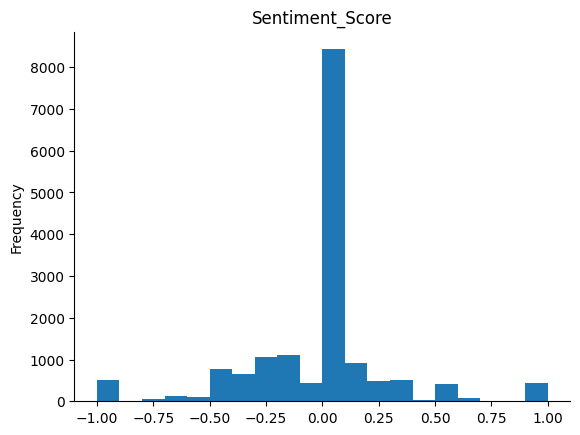

In [ ]:
from matplotlib import pyplot as plt
daily_sentiment['Sentiment_Score'].plot(kind='hist', bins=20, title='Sentiment_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
headline_counts.head()

,Date,Stock,headline_count
0,2009-08-07,MSFT,2
1,2009-08-07,NVDA,1
2,2009-08-10,AAPL,5
3,2009-08-10,AMZN,1
4,2009-08-10,MSFT,1


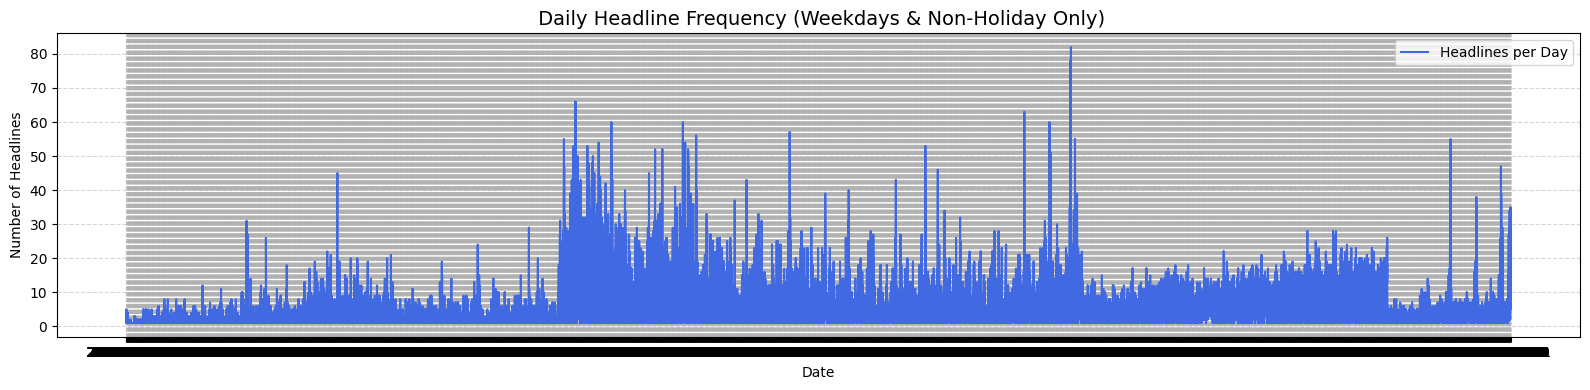

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(headline_counts["Date"], headline_counts["headline_count"], label="Headlines per Day", color="royalblue")
plt.title(" Daily Headline Frequency (Weekdays & Non-Holiday Only)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
processed_df['HeadlineCount'] = processed_df.groupby(['Date', 'Stock'])['Headlines'].transform('count')
processed_df['Weight'] = 1 / processed_df['HeadlineCount']
processed_df['Weighted_Sentiment'] = processed_df['Sentiment_Score'] * processed_df['Weight']

daily_weighted_sentiment = (
    processed_df.groupby(['Date', 'Stock'])['Weighted_Sentiment'].sum().reset_index()
)


In [ ]:
daily_weighted_sentiment.head()

,Date,Stock,Weighted_Sentiment
0,2009-08-07,MSFT,0.0
1,2009-08-07,NVDA,0.0
2,2009-08-10,AAPL,0.0
3,2009-08-10,AMZN,0.0
4,2009-08-10,MSFT,0.0


In [ ]:
sentiment_pivot = processed_df.groupby(['Date', 'Sentiment_Label']).size().unstack(fill_value=0).reset_index()


In [ ]:
sentiment_pivot.head()

Sentiment_Label,Date,negative,neutral,positive
0,2009-08-07,0,3,0
1,2009-08-10,0,7,0
2,2009-08-12,0,1,0
3,2009-08-14,0,2,0
4,2009-08-16,0,2,0


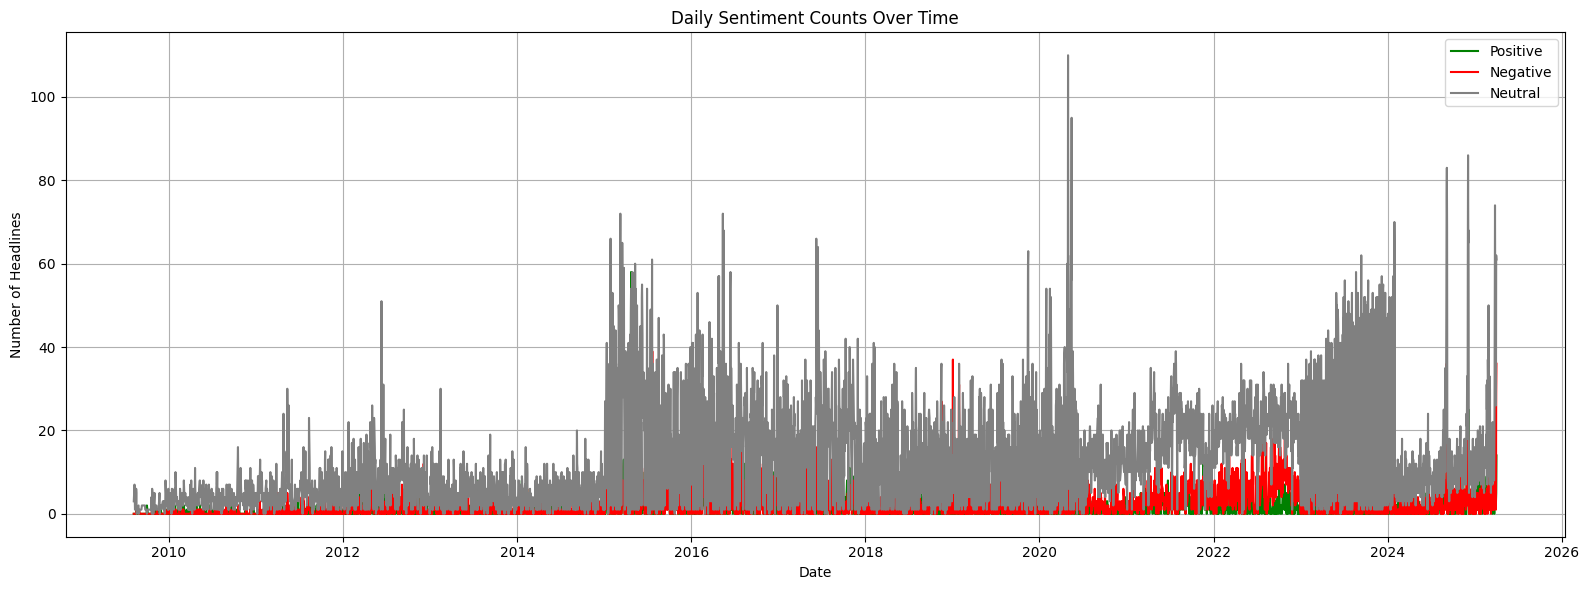

In [ ]:
sentiment_pivot['Date'] = pd.to_datetime(sentiment_pivot['Date'])

plt.figure(figsize=(16, 6))

plt.plot(sentiment_pivot['Date'], sentiment_pivot['positive'], label='Positive', color='green', linewidth=1.5)
plt.plot(sentiment_pivot['Date'], sentiment_pivot['negative'], label='Negative', color='red', linewidth=1.5)
plt.plot(sentiment_pivot['Date'], sentiment_pivot['neutral'], label='Neutral', color='gray', linewidth=1.5)

plt.title('Daily Sentiment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Headlines')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<Axes: xlabel='Weighted_Sentiment', ylabel='Count'>

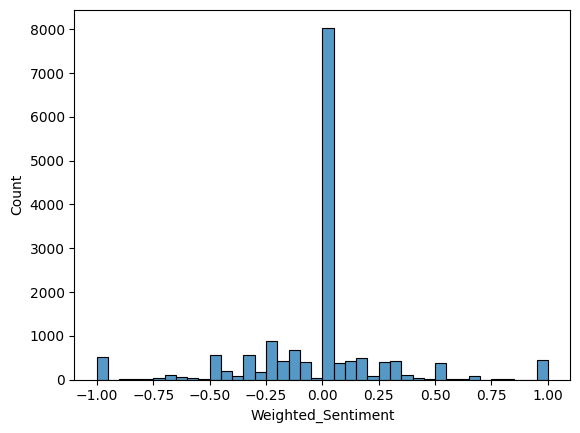

In [ ]:
import seaborn as sns
sns.histplot(daily_weighted_sentiment['Weighted_Sentiment'], bins=40)

In [ ]:
daily_counts = processed_df.groupby('Date').size()

daily_sentiment = processed_df.groupby('Date')['Sentiment_Score'].mean()

merged = pd.DataFrame({'headline_count': daily_counts, 'mean_sentiment': daily_sentiment})
merged['is_zero_sentiment'] = (merged['mean_sentiment'].abs() < 1e-5)


In [ ]:
merged

,headline_count,mean_sentiment,is_zero_sentiment
Date,,,
2009-08-07,3,0.000000,True
2009-08-10,7,0.000000,True
2009-08-12,1,0.000000,True
2009-08-14,2,0.000000,True
2009-08-16,2,0.000000,True
...,...,...,...
2025-03-28,92,-0.228261,False
2025-03-29,37,0.081081,False
2025-03-30,30,0.066667,False


In [ ]:
processed_df['Sentiment_Label'].value_counts()


,count
Sentiment_Label,
neutral,67269
negative,13920
positive,10228


In [ ]:
daily_weighted_sentiment.head()

,Date,Stock,Weighted_Sentiment
0,2009-08-07,MSFT,0.0
1,2009-08-07,NVDA,0.0
2,2009-08-10,AAPL,0.0
3,2009-08-10,AMZN,0.0
4,2009-08-10,MSFT,0.0


In [ ]:
processed_df.head()

,Date,Headlines,Stock,Processed_Headlines,Sentiment_Label,Sentiment_Score,HeadlineCount,Weight,Weighted_Sentiment
0,2009-08-07,dave sawyer from microsoft and bob nolan from ...,MSFT,dave sawyer microsoft bob nolan raxco software...,neutral,0,2,0.5,0.0
1,2009-08-07,study: enterprises can slash 88 percent off ap...,MSFT,study enterprises slash percent application pr...,neutral,0,2,0.5,0.0
2,2009-08-07,paragonreport.com complimentary market update ...,NVDA,paragonreportcom complimentary market update a...,neutral,0,1,1.0,0.0
3,2009-08-10,thefortunefinancial.com free market research o...,AAPL,thefortunefinancialcom free market research fw...,neutral,0,5,0.2,0.0
4,2009-08-10,"new ""transformer(tm)"" for ipod/iphone and ""tra...",AAPL,new transformertm ipodiphone transformer setm ...,neutral,0,5,0.2,0.0


In [ ]:
import joblib
le = joblib.load('stock_type_encoder.pkl')
daily_sentiment = (
    processed_df.groupby(['Date', 'Stock']).agg({
        'Weighted_Sentiment': 'sum',
        'Sentiment_Score': 'mean',
        'Headlines': 'count'
    }).reset_index()
)
daily_sentiment['Stock'] = le.transform(daily_sentiment['Stock'])
daily_sentiment.columns = ['Date', 'Stock Type', 'Weighted_Sentiment', 'Mean_Sentiment', 'Headline_Count']


In [ ]:
daily_sentiment

,Date,Stock Type,Weighted_Sentiment,Mean_Sentiment,Headline_Count
0,2009-08-07,3,0.000000,0.000000,2
1,2009-08-07,4,0.000000,0.000000,1
2,2009-08-10,0,0.000000,0.000000,5
3,2009-08-10,1,0.000000,0.000000,1
4,2009-08-10,3,0.000000,0.000000,1
...,...,...,...,...,...
16128,2025-04-01,0,0.047619,0.047619,21
16129,2025-04-01,1,-0.187500,-0.187500,16
16130,2025-04-01,2,-0.444444,-0.444444,27
16131,2025-04-01,3,-0.222222,-0.222222,18


Text(0.5, 1.0, 'Distribution of Daily Weighted Sentiment Scores')

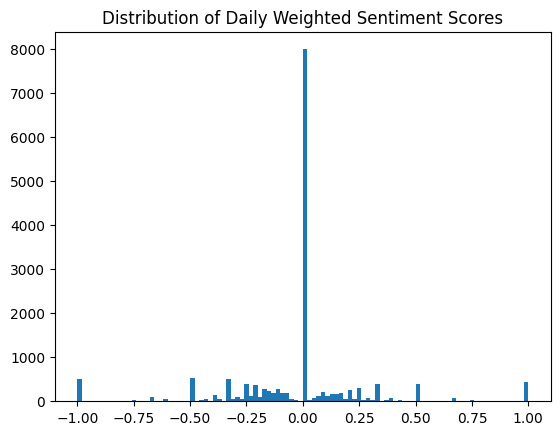

In [ ]:
plt.hist(daily_sentiment['Weighted_Sentiment'], bins=100)
plt.title("Distribution of Daily Weighted Sentiment Scores")

In [ ]:
def label_sentiment(score, threshold=0.075):
    if score > threshold:
        return 'positive'
    elif score < -threshold:
        return 'negative'
    else:
        return 'neutral'

daily_sentiment['Sentiment_Label'] = daily_sentiment['Weighted_Sentiment'].apply(label_sentiment)

print(daily_sentiment['Sentiment_Label'].value_counts())


Sentiment_Label
neutral     8361
negative    4591
positive    3181
Name: count, dtype: int64


In [ ]:
daily_sentiment.head()

,Date,Stock Type,Weighted_Sentiment,Mean_Sentiment,Headline_Count,Sentiment_Label
0,2009-08-07,3,0.0,0.0,2,neutral
1,2009-08-07,4,0.0,0.0,1,neutral
2,2009-08-10,0,0.0,0.0,5,neutral
3,2009-08-10,1,0.0,0.0,1,neutral
4,2009-08-10,3,0.0,0.0,1,neutral


In [ ]:
senti_fuse_ready_df = daily_sentiment.copy()



In [ ]:
senti_fuse_ready_df

,Date,Stock Type,Weighted_Sentiment,Mean_Sentiment,Headline_Count,Sentiment_Label
0,2009-08-07,3,0.000000,0.000000,2,neutral
1,2009-08-07,4,0.000000,0.000000,1,neutral
2,2009-08-10,0,0.000000,0.000000,5,neutral
3,2009-08-10,1,0.000000,0.000000,1,neutral
4,2009-08-10,3,0.000000,0.000000,1,neutral
...,...,...,...,...,...,...
16128,2025-04-01,0,0.047619,0.047619,21,neutral
16129,2025-04-01,1,-0.187500,-0.187500,16,negative
16130,2025-04-01,2,-0.444444,-0.444444,27,negative
16131,2025-04-01,3,-0.222222,-0.222222,18,negative


In [ ]:
senti_fuse_ready_df.to_csv(sentiment_data_path / 'sentiment_fuse_ready.csv', index=False)